#### load the nessary pacages

In [25]:
import rasterio
import numpy as np
import os
import joblib # For loading your trained ML model
from pathlib import Path
from shapely.geometry import Polygon, mapping
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx # For adding basemaps

#### Configuration

<- define config file path

```bash
script_dir = Path(__file__).parent  # E:\Research\Research_Prepare\src\Sample
script_dir  
src_dir = script_dir.parent  # E:\Research\Research_Prepare\src
root_dir = src_dir.parent  # E:\Research\Research_Prepare
```

In [26]:
root_dir = Path("../../")   # Adjust this path to your project root
src_dir = root_dir / "src"  # Path to your source directory
# Path to your multispectral UAV image
UAV_IMAGE_PATH = root_dir / "temp" / "odm_orthophoto" / "odm_orthophoto.tif"
if not UAV_IMAGE_PATH.exists():
    raise FileNotFoundError(f"UAV image not found at {UAV_IMAGE_PATH}")
# Path to your trained ML model
ML_MODEL_PATH = src_dir / "model" / "xgb_model_v3.joblib" 
if not ML_MODEL_PATH.exists():
    raise FileNotFoundError(f"ML model not found at {ML_MODEL_PATH}")

In [27]:
PATCH_SIZE = 64 # Pixels for square patches

# Threshold for filtering "informationless" patches:
# Sum of all pixel values across all bands in a patch.
# Adjust this value based on your data. A very low sum indicates black/empty areas.
MIN_PIXEL_SUM_THRESHOLD = 5000 # Example: Tune this value!

# Define your growth stages in the order your model predicts them (0, 1, 2, ...)
GROWTH_STAGES = ["germination", "tillering", "grand_growth", "ripening"]

# Output GeoJSON file for map visualization
OUTPUT_GEOJSON_PATH = "sugarcane_growth_patches.geojson"

# Output image for the desktop map visualization
OUTPUT_MAP_IMAGE_PATH = "sugarcane_field_growth_map.png"

# Band mapping for your UAV image
BAND_MAPPING = {
    "RED": 0,
    "NIR": 4,
    "SWIR": 1
}

MODL_PATH = src_dir / "model" / "xgb_model_v3.joblib"

<<<--- testing

In [28]:
print(f"Using band mapping: {BAND_MAPPING}")

Using band mapping: {'RED': 0, 'NIR': 4, 'SWIR': 1}


In [29]:
# Function to read the UAV image and extract bands
with rasterio.open(UAV_IMAGE_PATH) as src:
        image = src.read()  # Reads all bands into a NumPy array
        profile = src.profile  # Save profile for GeoTIFF metadata
        description = src.descriptions  # Band descriptions if available
        
print(f"Image shape: {image.shape}")  # Should be (bands, height, width)
print(f"Image profile: {profile}")  # Check metadata for CRS, transform, etc.
print(f"Band descriptions: {description}")  # Useful for understanding band order

    

Image shape: (6, 1760, 1322)
Image profile: {'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1322, 'height': 1760, 'count': 6, 'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 44N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",81],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32644"]]'), 'transform': Affine(0.04998595505613276, 0.0, 575877.3194171236,
       0.0, -0.04998374037942002, 804183.3428130195), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'pixel'}
Band descriptions:

In [30]:
train_on_of_img_dir = root_dir/"data/MULTISPECTRAL/grand_growth/crop_main/grand_growth_main.tif"

if not train_on_of_img_dir.exists():
    raise FileNotFoundError(f"Patch image not found at {train_on_of_img_dir}")

with rasterio.open(train_on_of_img_dir) as src:
    train_patch_img = src.read()  # Reads all bands into a NumPy array
    train_patch_profile = src.profile  # Save profile for GeoTIFF metadata
    train_patch_description = src.descriptions  # Band descriptions if available
    
    t1, t2, t3 = train_patch_img[3], train_patch_img[2], train_patch_img[1]  # Assuming NIR, RED, GREEN order
    
    print("<>>>>>>> Train patch band descriptions <<<<<<<<")
    print(f'T1 description: {train_patch_description[3]}')
    print(f'T2 description: {train_patch_description[2]}')
    print(f'T3 description: {train_patch_description[1]}')
    print(">>>>>>>> End of train patch band descriptions <<<<<<<<")

print(f"Train patch image shape: {train_patch_img.shape}")  # Should be (bands, height, width)
print(f"Train patch profile: {train_patch_profile}")  # Check metadata for CRS, transform, etc.
print(f"Train patch band descriptions: {train_patch_description}")  # Useful for understanding band

c:\Users\user\anaconda3\envs\research_env\lib\site-packages\rasterio\__init__.py:368: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


<>>>>>>> Train patch band descriptions <<<<<<<<
T1 description: RedEdge
T2 description: Red
T3 description: Green
>>>>>>>> End of train patch band descriptions <<<<<<<<
Train patch image shape: (5, 3887, 5277)
Train patch profile: {'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 5277, 'height': 3887, 'count': 5, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'blockxsize': 5277, 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}
Train patch band descriptions: ('Blue', 'Green', 'Red', 'RedEdge', 'NIR')


In [31]:
# Correct band mapping
BAND_MAPPING_CORRECT_Fix4D = {
    "BLUE": 0,
    "GREEN": 1,
    "RED": 2,
    "RED_EDGE": 3,
    "NIR": 4,
}

BAND_MAPPING_CORRECT_ODM = {
    "RED": 0,
    "GREEN": 1,
    "BLUE": 2,
    "NIR": 3,
    "RED_EDGE": 4,
}

print(f"Using corrected band mapping from Fix4D : {BAND_MAPPING_CORRECT_Fix4D}")
print(f"Using corrected band mapping from ODM : {BAND_MAPPING_CORRECT_ODM}")

Using corrected band mapping from Fix4D : {'BLUE': 0, 'GREEN': 1, 'RED': 2, 'RED_EDGE': 3, 'NIR': 4}
Using corrected band mapping from ODM : {'RED': 0, 'GREEN': 1, 'BLUE': 2, 'NIR': 3, 'RED_EDGE': 4}


#### Utility Functions

In [ ]:
def calculate_ndvi(nir_band, red_band):
    """Calculates Normalized Difference Vegetation Index (NDVI)."""
    return (nir_band - red_band) / (nir_band + red_band + 1e-10)

def calculate_ndwi(nir_band, swir_band):
    """Calculates Normalized Difference Water Index (NDWI)."""
    # nwir_band ---> geen_band 
    # NDWI = (green_band - nir_band) / (green_band + nir_band + 1e-10 )
    return (nir_band - swir_band) / (nir_band + swir_band + 1e-10)


def extract_features_from_patch_array(patch_array):
    """
    Extracts features from a single multispectral patch NumPy array.
    Expects patch_array shape: (num_bands, height, width)
    """
    features = []
    # Safely get band data using BAND_MAPPING
    try:
        red_band = patch_array[BAND_MAPPING["RED"]]
        nir_band = patch_array[BAND_MAPPING["NIR"]]
        swir_band = patch_array[BAND_MAPPING["SWIR"]]
        
        # Calculate NDVI and NDWI
        ndvi = calculate_ndvi(nir_band, red_band)
        ndwi = calculate_ndwi(nir_band, swir_band)
        
        features = [
            np.mean(ndvi), np.std(ndvi),
            np.mean(ndwi), np.std(ndwi),
            np.percentile(nir_band, 75),
            np.mean(swir_band > np.quantile(swir_band, 0.75))
        ]
        
        return np.array(features)
    except KeyError as e:
        raise ValueError(f"Missing required band in patch: {e}")

#### Main Processing Logic

In [33]:
def process_field_for_mapping(image_path: Path, ml_model, growth_stages: list,
                              patch_size: int = 64, min_pixel_sum_threshold: int = 1000) -> Path:
    """
    Processes a multispectral GeoTIFF, extracts valid patches,
    predicts growth stages in batch, and generates a GeoJSON file.

    Args:
        image_path (Path): Path to the input multispectral GeoTIFF.
        ml_model: Loaded scikit-learn compatible ML model.
        growth_stages (list): List of growth stage names corresponding to model's labels.
        patch_size (int): Size of the square patches (e.g., 64).
        min_pixel_sum_threshold (int): Patches with a total pixel sum below this
                                       threshold will be considered "informationless" (black)
                                       and skipped. Tune this value.

    Returns:
        Path: Path to the generated GeoJSON file.
    """
    print(f">>>>>>>>>>--------- Starting processing for: {image_path.name} ---------<<<<<<<<<<", flush=True)
    
    patches_to_process = [] # Stores (patch_data, r_start, c_start)
    
    with rasterio.open(image_path) as src:
        # Read all image data once for memory efficiency in patch extraction
        # This assumes the image fits in memory. For extremely large images,
        # you'd need to process by window.
        image_data = src.read() 
        profile = src.profile
        transform = src.transform
        nodata_val = src.nodata
        
        bands, h, w = image_data.shape
        print(f"Image dimensions: {h}x{w} pixels, {bands} bands.", flush=True)
        
        num_patches_skipped = 0
        total_possible_patches = 0
        i = 0  # Patch index for debugging

        for r_start in range(0, h, patch_size):
            for c_start in range(0, w, patch_size):
                total_possible_patches += 1
                r_end = r_start + patch_size
                c_end = c_start + patch_size

                # Ensure patch fits exactly within image bounds
                # if r_end > h or c_end > w:
                #     # Skip partial patches at the edges for simplicity.
                #     # Alternatively, you could pad them to PATCH_SIZE if your model handles it.
                #     num_patches_skipped += 1
                #     continue

                patch_data = image_data[:, r_start:r_end, c_start:c_end]
                #print(patch_data.shape)
                
                # --- Filtering for "informationless" patches ---
                # 1. Check for nodata values (if defined in GeoTIFF)
                if nodata_val is not None and np.all(patch_data == nodata_val):
                    #print(f"----->{i} Skipping patch at {r_start},{c_start}: All pixels are nodata ({nodata_val}).", flush=True)
                    patches_to_process.append((patch_data, r_start, c_start, "skip"))
                    num_patches_skipped += 1
                    #print(f"----->{i} num_patches_skipped: {num_patches_skipped} <-----", flush=True)
                    continue
                
                # # 2. Check if the patch is mostly black/very low intensity
                if np.sum(patch_data) < min_pixel_sum_threshold:
                    #print(f"----->{i} Skipping patch at {r_start},{c_start}: Total pixel sum is too low ({np.sum(patch_data)}).", flush=True)
                    patches_to_process.append((patch_data, r_start, c_start, "skip"))
                    num_patches_skipped += 1
                    #print(f"----->{i} num_patches_skipped: {num_patches_skipped} <-----", flush=True)
                    continue
                
                # # 3. Basic check for sufficient band data for feature extraction
                if patch_data.shape[0] < max(BAND_MAPPING.values()) + 1:
                    #print(f"----->{i} Skipping patch at {r_start},{c_start}: Not enough bands ({patch_data.shape[0]}) for required indexing.", flush=True)
                    patches_to_process.append((patch_data, r_start, c_start, "skip"))
                    num_patches_skipped += 1
                    #print(f"----->{i} num_patches_skipped: {num_patches_skipped} <-----", flush=True)
                    continue

                patches_to_process.append((patch_data, r_start, c_start, "valid"))
                i+= 1  # Increment patch index for debugging

    valid_patches = [p for p in patches_to_process if p[3] == "valid"]           
    #print(f"valid patches to process: {len(valid_patches)} out of {total_possible_patches} possible patches.", flush=True)
                
    print(f"===> Found {len(valid_patches)} valid patches to process out of {total_possible_patches} possible patches.", flush=True)
    print(f"===> Skipped {num_patches_skipped} informationless/partial patches.", flush=True)
    print(f"===> Total patches to process: {len(patches_to_process)}", flush=True)
    
    if not patches_to_process:
        print("No valid patches found to process. Exiting.", flush=True)
        return None
    
    # --- Batch Feature Extraction ---
    print("===> Extracting features in batch...", flush=True)
    # Extract features for all valid patches
    # Use list comprehension for efficient feature extraction
    all_features = []
    for patch_data, r_start, c_start, status in patches_to_process:
        if status == "valid":
            try:
                features = extract_features_from_patch_array(patch_data)
                #print(f"Extracted features for patch at {r_start},{c_start}: {features}", flush=True)
                # p[0] = features  # Replace patch data with extracted features
                all_features.append(features)
            except ValueError as e:
                print(f"Error extracting features from patch at {p[1]},{p[2]}: {e}", flush=True)
    
    #all_features = [extract_features_from_patch_array(p[0]) for p in patches_to_process if p[3] == "valid"]
    
    # Filter out patches where feature extraction failed (returned NaNs)
    valid_features_and_indices = []
    for i, features in enumerate(all_features):
        if not any(np.isnan(f) for f in features): # Check if any feature is NaN
            valid_features_and_indices.append((features, i))
        else:
            print(f"Skipping patch {i} due to invalid features (NaN/Inf).", flush=True)
    #valid_features_and_indices.append((features, i))
    # print(f"Extracted features for {len(valid_features_and_indices)} valid patches.", flush=True)
    # print(valid_features_and_indices)

    if not valid_features_and_indices:
        print("No valid features extracted after filtering. Exiting.", flush=True)
        return None

    # Separate features and original indices
    features_for_prediction = np.array([item[0] for item in valid_features_and_indices])
    original_patch_indices = [item[1] for item in valid_features_and_indices]
    
    print(f"===> Successfully extracted features for {len(features_for_prediction)} patches.", flush=True)
    
    # --- Batch Prediction ---
    print("===> Performing batch prediction...", flush=True)
    # print(f"Features shape: {features_for_prediction.shape}", flush=True)
    # print(features_for_prediction)
    predictions_labels = []
    for i, features in enumerate(features_for_prediction):
        # print(f"Predicting for patch {i} with features: {features}", flush=True)
        try:
            label = ml_model.predict([features])[0]  # Predict single patch
            predictions_labels.append(label)
        except Exception as e:
            print(f"Error predicting for patch {i}: {e}", flush=True)
            predictions_labels.append(-1)
    # predictions_labels = ml_model.predict(features_for_prediction)
    predictions_stages = [growth_stages[label] for label in predictions_labels]
    
    #print(predictions_stages)
    
    print("===> Prediction complete. Next generating GeoJSON.", flush=True)
    
    # --- GeoJSON Generation ---
    geojson_features = []
    with rasterio.open(image_path) as src:
        transform = src.transform

        prediction_index_map = dict(zip(original_patch_indices, predictions_stages))  # Map index → predicted stage
        # print(f"----> Prediction index map: {prediction_index_map}", flush=True)
        # print(f"----> Generating GeoJSON features for {len(patches_to_process)} patches.", flush=True)

        for i, patch in enumerate(patches_to_process):
            _patch_data, r_start, c_start, status = patch

            # print(f"{i} -- Patch data shape: {_patch_data.shape}", flush=True)
            # print(f"{i} -- Processing patch at {r_start},{c_start} with status: {status}", flush=True)

            # Calculate geo-coordinates of patch corners
            ul_lon, ul_lat = transform * (c_start, r_start)
            ur_lon, ur_lat = transform * (c_start + patch_size, r_start)
            lr_lon, lr_lat = transform * (c_start + patch_size, r_start + patch_size)
            ll_lon, ll_lat = transform * (c_start, r_start + patch_size)

            patch_polygon = Polygon([
                (ul_lon, ul_lat),
                (ur_lon, ur_lat),
                (lr_lon, lr_lat),
                (ll_lon, ll_lat),
                (ul_lon, ul_lat)  # Close the polygon
            ])

            # Set growth stage from prediction or None if skipped
            growth_stage = prediction_index_map.get(i, None)
            # print(f"Patch {i} at {r_start},{c_start} has growth stage: {growth_stage}", flush=True)
            # print(f"Patch Status: {status}", flush=True)

            geojson_features.append({
                "type": "Feature",
                "geometry": mapping(patch_polygon),
                "properties": {
                    "growth_stage": growth_stage,
                    "row_start": r_start,
                    "col_start": c_start,
                }
            })

            
    # print(f"===> Generated {len(geojson_features)} GeoJSON features.", flush=True)
    # print(geojson_features)
    
    
    output_geojson_data = {
        "type": "FeatureCollection",
        "crs": {
            "type": "name",
            "properties": {"name": f"EPSG:{src.crs.to_epsg()}"}
        },
        "features": geojson_features
    }

    with open(OUTPUT_GEOJSON_PATH, "w") as f:
        json.dump(output_geojson_data, f, indent=2)

    print(f"----> GeoJSON data saved to {OUTPUT_GEOJSON_PATH}", flush=True)
    print("===> Processing complete. GeoJSON file generated.", flush=True)
    return Path(OUTPUT_GEOJSON_PATH)
                
                

In [34]:
#load the ML model
if not MODL_PATH.exists():
    raise FileNotFoundError(f"Model not found at {MODL_PATH}")
ml_model = joblib.load(MODL_PATH)
print("====================================================")
print(process_field_for_mapping(UAV_IMAGE_PATH, ml_model, GROWTH_STAGES, PATCH_SIZE, MIN_PIXEL_SUM_THRESHOLD))

>>>>>>>>>>--------- Starting processing for: odm_orthophoto.tif ---------<<<<<<<<<<
Image dimensions: 1760x1322 pixels, 6 bands.
===> Found 253 valid patches to process out of 588 possible patches.
===> Skipped 335 informationless/partial patches.
===> Total patches to process: 588
===> Extracting features in batch...
===> Successfully extracted features for 253 patches.
===> Performing batch prediction...
===> Prediction complete. Next generating GeoJSON.
----> GeoJSON data saved to sugarcane_growth_patches.geojson
===> Processing complete. GeoJSON file generated.
sugarcane_growth_patches.geojson


#### Map Visualization Logic

In [35]:
def display_growth_stage_map(geojson_path: Path, output_map_path: Path, growth_stages: list):
    """
    Loads GeoJSON data and displays it on a map using geopandas and matplotlib.
    Saves the map as an image.
    """
    print(f">>>>>>>>>>--------- Loading GeoJSON for mapping: {geojson_path.name} ---------<<<<<<<<<<", flush=True)
    
    try:
        gdf = gpd.read_file(geojson_path)
    except Exception as e:
        print(f"----> Error loading GeoJSON: {e}. Ensure the file is valid.", flush=True)
        return

    if gdf.empty:
        print("----> GeoJSON file is empty. Nothing to map.", flush=True)
        return

    print(f"===> Successfully loaded {len(gdf)} features for mapping.", flush=True)
    
    # Define a color map for your growth stages
    # Assign distinct colors to each stage
    stage_colors_map = {
        "germination": "#a1d99b", # Light Green
        "tillering": "#74c476",   # Medium Green
        "grand_growth": "#31a354", # Dark Green
        "ripening": "#fd8d3c",    # Orange
        'unknown': 'gray'
        # Add more if you have other stages and ensure they match GROWTH_STAGES
    }
    
     # Prepare for plotting
    fig, ax = plt.subplots(1, 1, figsize=(15, 15)) # Adjust figure size as needed

    # Reproject GeoDataFrame to Web Mercator (EPSG:3857) for `contextily` basemaps
    # Check if CRS is already 3857 or 4326 (WGS84). If 4326, reproject.
    if gdf.crs is None:
        print("----> Warning: GeoDataFrame has no CRS. Assuming WGS84 (EPSG:4326).", flush=True)
        gdf = gdf.set_crs(epsg=4326) # Set to common GPS CRS
    else:
        print(f"----> GeoDataFrame CRS: {gdf.crs}", flush=True)
        
    gdf_proj = gdf.to_crs(epsg=3857) # Reproject for basemap
    print(f"----> Reprojected GeoDataFrame CRS: {gdf_proj.crs}", flush=True)
    
    # Plot the patches, colored by 'growth_stage'
    # Use categorical plotting for a proper legend
    gdf_proj.plot(column='growth_stage',
                  cmap=plt.colormaps['viridis'], # A generic colormap, can be customized
                  categorical=True, # Important for proper legend and color assignment
                  legend=True,
                  legend_kwds={'title': 'Growth Stage', 'loc': 'lower left'},
                  edgecolor='black',
                  linewidth=0.5,
                  ax=ax,
                  missing_kwds={
                    "color": "lightgrey",
                    "edgecolor": "red",
                    "hatch": "///",
                    "label": "Missing values",
                  }
                 )
    
    # Custom color assignment for exact stage_colors_map control:
    # Get unique stages present in the data for robust colormapping
    unique_stages_in_data = gdf_proj['growth_stage'].unique()
    colors = [stage_colors_map.get(stage, 'gray') for stage in unique_stages_in_data]
    
    # Create a custom legend manually if needed, or rely on automatic categorical plot legend.
    # The automatic one (above) is usually good, but if you need exact colors matching
    # your `stage_colors_map`, you'd do:
    # from matplotlib.colors import ListedColormap
    # # Create a colormap for the stages found in data
    # cmap_custom = ListedColormap([stage_colors_map.get(s, 'gray') for s in sorted(unique_stages_in_data)])
    
    # gdf_proj.plot(column='growth_stage',
    #               cmap=cmap_custom,
    #               categorical=True,
    #               legend=True,
    #               legend_kwds={'title': 'Growth Stage', 'loc': 'lower left', 'bbox_to_anchor': (1, 0.5)}, # Example adjust legend position
    #               edgecolor='black',
    #               linewidth=0.5,
    #               ax=ax
    #              )


    # # Add a basemap for context
    # try:
    #     # cx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=cx.providers.Esri.WorldImagery) # Satellite imagery
    #     cx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik) # Satellite imagery
        
    #     # cx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik) # OpenStreetMap
    # except Exception as e:
    #     print(f"Could not add basemap: {e}. Check internet connection or Contextily providers.", flush=True)

    # ax.set_title(f'Sugarcane Field Growth Stages - {UAV_IMAGE_PATH.name}')
    # ax.set_axis_off() # Hide axes for a cleaner map look

    # plt.tight_layout() # Adjust layout to prevent labels/legend overlapping
    
    # # Save the map to an image file
    # # plt.savefig(output_map_path, dpi=300, bbox_inches='tight')
    # # print(f"Map saved to {output_map_path}", flush=True)

    # # Display the plot (optional, will open a window)
    # plt.show()
    
    from matplotlib.colors import ListedColormap

    # Ensure no None values in growth_stage
    gdf_proj['growth_stage'] = gdf_proj['growth_stage'].fillna('unknown')
    unique_stages_in_data = gdf_proj['growth_stage'].unique()

    # Create a colormap for the stages found in data
    cmap_custom = ListedColormap([stage_colors_map.get(s, 'gray') for s in sorted(unique_stages_in_data)])

    gdf_proj.plot(column='growth_stage',
                cmap=cmap_custom,
                categorical=True,
                legend=True,
                legend_kwds={'title': 'Growth Stage', 'loc': 'lower left', 'bbox_to_anchor': (1, 0.5)},
                edgecolor='black',
                linewidth=0.5,
                ax=ax)

    # Add a basemap for context
    try:
        cx.add_basemap(ax, crs=gdf_proj.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)
    except Exception as e:
        print(f"Could not add basemap: {e}. Check internet connection or Contextily providers.", flush=True)

    ax.set_title(f'Sugarcane Field Growth Stages - {UAV_IMAGE_PATH.name}')
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()

## Debugging

In [14]:
# start debugging
JSON_PATH = Path(OUTPUT_GEOJSON_PATH)
# Check if the GeoJSON file exists before proceeding
if not JSON_PATH.exists():
    raise FileNotFoundError(f"GeoJSON file not found at {JSON_PATH}")
# print json file name
print(f"Displaying growth stage map from GeoJSON: {JSON_PATH.name}", flush=True)

# read the GeoJSON file
geo_json_obj = gpd.read_file(JSON_PATH)
print(f"GeoJSON file loaded with {len(geo_json_obj)} features.", flush=True)
# print the first few rows
#print(geo_json_obj.head())
# print the columns
print(f"GeoJSON columns: {geo_json_obj.columns.tolist()}", flush=True)
# print the properties of the first feature
print(f"First feature properties: {geo_json_obj.iloc[0].to_dict()}", flush=True)


print(f"GeoJSON CRS: {geo_json_obj.crs}", flush=True)
print(f"GeoJSON bounds: {geo_json_obj.total_bounds}", flush=True)
# print type of geo_json_obj
print(f"GeoJSON type: {type(geo_json_obj)}", flush=True)

Displaying growth stage map from GeoJSON: sugarcane_growth_patches.geojson


GeoJSON file loaded with 588 features.
GeoJSON columns: ['growth_stage', 'row_start', 'col_start', 'geometry']
First feature properties: {'growth_stage': 'grand_growth', 'row_start': 0, 'col_start': 0, 'geometry': <POLYGON ((575877.319 804183.343, 575880.519 804183.343, 575880.519 804180.1...>}
GeoJSON CRS: EPSG:4326
GeoJSON bounds: [575877.31941712 804093.77195026 575944.50054072 804183.34281302]
GeoJSON type: <class 'geopandas.geodataframe.GeoDataFrame'>


In [16]:
print(geo_json_obj.geometry.is_valid.all())  # Check if all geometries are valid
print(geo_json_obj.geometry.is_empty.any())  # Check if any geometries are empty
print(geo_json_obj.geometry.isna().any())    # Check for missing geometries

True
False
False


In [21]:
print(geo_json_obj.total_bounds)  # Should return [minx, miny, maxx, maxy]
print(geo_json_obj.crs)  # Check the CRS

if geo_json_obj.crs == "EPSG:4326":
    print("GeoJSON CRS is EPSG:4326 (WGS84). Reprojecting to EPSG:3857 for mapping.", flush=True)
    geo_json_obj = geo_json_obj.to_crs(epsg=3857)
    
print(f"Reprojected GeoJSON CRS: {geo_json_obj.crs}", flush=True)

[575877.31941712 804093.77195026 575944.50054072 804183.34281302]
EPSG:4326
GeoJSON CRS is EPSG:4326 (WGS84). Reprojecting to EPSG:3857 for mapping.
Reprojected GeoJSON CRS: EPSG:3857


Text(0.5, 1.0, 'Sugarcane Growth Stages')

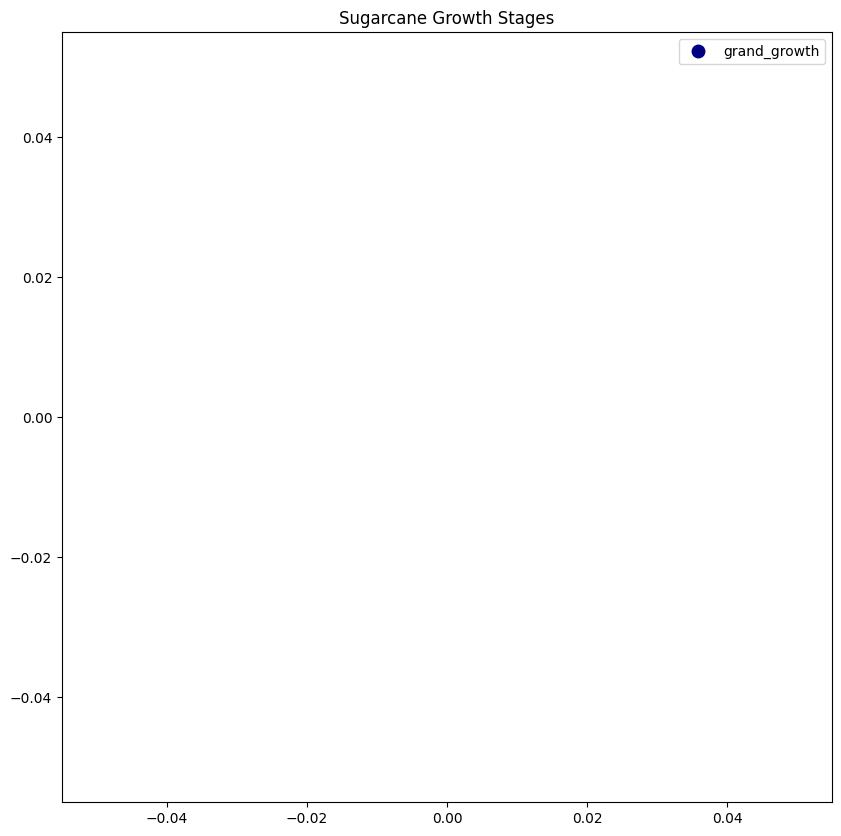

In [24]:
geo_json_obj.plot(column='growth_stage', figsize=(10, 10), legend=True, cmap='jet', edgecolor='black', linewidth=0.5)
plt.title('Sugarcane Growth Stages')

In [ ]:
# test display_growth_stage_map function
JSON_PATH = Path(OUTPUT_GEOJSON_PATH)
if not JSON_PATH.exists():
    raise FileNotFoundError(f"GeoJSON file not found at {JSON_PATH}")

display_growth_stage_map(JSON_PATH, Path(OUTPUT_MAP_IMAGE_PATH), GROWTH_STAGES)

